# IERG 5350 Assignment 4: Reinforcement Learning Pipeline in Practice


**You are not required to have to write anything in this notebook**. But you can always play with this notebook if you find the code here useful to prepare your submission. We only grade your assignment based on the PDF file and those TODOs in code.


# Section 1: Get familiar with the environment

We prepared a set of pre-defined MetaDrive environments to train your agents. 

The first is `MetaDrive-Tut-Easy-v0`, which only has one map with only a straight road.

The second is `MetaDrive-Tut-Hard-v0`, which contains 10 maps, each map has three blocks with complex road network.

We also prepare a set of 

In this section, we first take a glance at these environments.

### **Please note that each MetaDrive can only run in single process. If you encounter any environmental error, please firstly try to restart the notebook and rerun the cell.**


In [ ]:
import gym
from core.utils import register_metadrive

register_metadrive()
env = gym.make("MetaDrive-Tut-Easy-v0", config={"use_render": True})
try:
    obs = env.reset()
    for i in range(200):
        obs, rew, term, _ = env.step(env.action_space.sample())
        if term:
            break
finally:
    env.close()

print("Demonstration finished!")

In [ ]:
import gym
from core.utils import register_metadrive

register_metadrive()
env = gym.make("MetaDrive-Tut-Hard-v0", config={"use_render": True})
try:
    for _ in range(10):
        obs = env.reset()
        for i in range(15):
            obs, rew, term, _ = env.step(env.action_space.sample())
        env.switch_to_top_down_view()  # Change to top-down view
        for i in range(15):
            obs, rew, term, _ = env.step(env.action_space.sample())
finally:
    env.close()

print("Demonstration finished!")

# Section 2: Implement base trainer

You should finish `compute_action` in `core/base_trainer.py`. Run the next cell to make sure the code is working.

In [1]:
%run core/base_trainer.py

/home/wenjj/Documents/02_Projects/ierg5350-assignment-2021/assignment4/core
Base trainer discrete case test passed!
Base trainer continuous case test passed!
Base trainer test passed!


# Section 3: Finish A2C trainer and training script

You need to implement `update` and `compute_loss` function in `core/a2c_trainer.py`.
You also need to implement the TODOs in `train.py`.

To compute the expected return which is then used to calculate the advantages, `A2CRolloutStorage` in `core/buffer.py` is also necessary.

Run the next cell to verify your code is working.

In [ ]:
%run train.py --env-id CartPole-v0 --algo A2C --log-dir CartPole --num-envs 10 --max-steps 300000

/home/wenjj/Documents/02_Projects/ierg5350-assignment-2021/assignment4/core
/home/wenjj/Documents/02_Projects/ierg5350-assignment-2021/assignment4/core
/home/wenjj/Documents/02_Projects/ierg5350-assignment-2021/assignment4/core
Start training!
===== A2C Training Iteration 0 =====:
  evaluate_stats: {}
  frame_per_second: 8157
  iteration: 0
  learning_stats:
    adv_mean: 12.938937187194824
    entropy: 0.693146288394928
    grad_norm: 0.5
    policy_loss: 8.967750549316406
    ratio: 0.0
    total_loss: 137.91250610351562
    value_loss: 257.90338134765625
  log_dir: /home/wenjj/Documents/02_Projects/ierg5350-assignment-2021/assignment4/CartPole/A2C
  success_rate:
    success_rate_max: .nan
    success_rate_mean: .nan
    success_rate_min: .nan
  time_stats:
    episode_time: 2.4224634170532227
    process_time: 0.06382322311401367
    sample_time: 2.34374737739563
    total_time: 2.4519948959350586
    update_time: 0.014892816543579102
  total_episodes: 907
  total_steps: 20000
  tr

Text(0.5, 0, 'Sampled Steps')

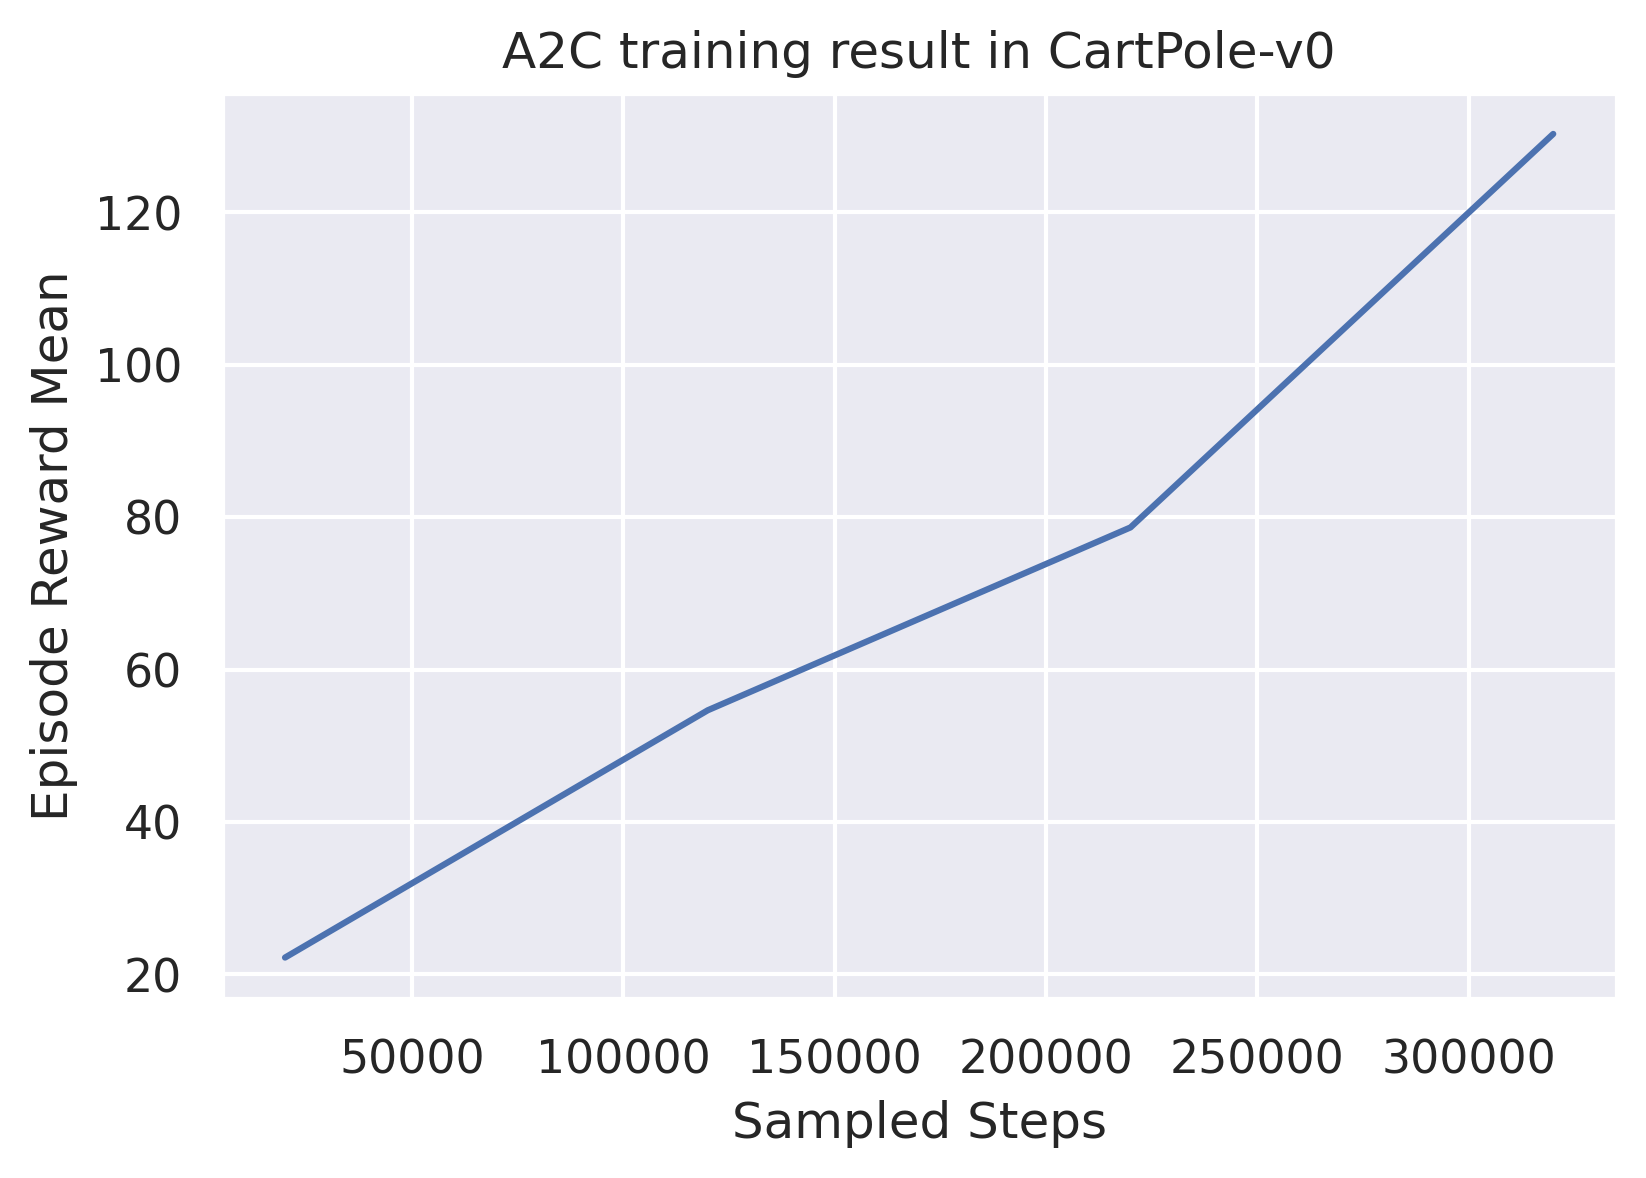

In [1]:
from core.utils import load_progress
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = load_progress("MetaDriveEasy/A2C")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="training_episode_reward/episode_reward_mean"
)
ax.set_title("A2C training result in CartPole-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")
# ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

# Note: The following figure is for reference used only, you don't have to repreduce it.

### Also train A2C in MetaDrive easy environment.

As you can see in the demonstrative figure below, A2C performs badly. This is expected, so don't worry!

In [ ]:
%run train.py --env-id MetaDrive-Tut-Easy-v0 --algo A2C --log-dir MetaDriveEasy \
  --num-envs 10 --max-steps 500000

Text(286666.6666666667, 1.1564489543437957, 'REF')

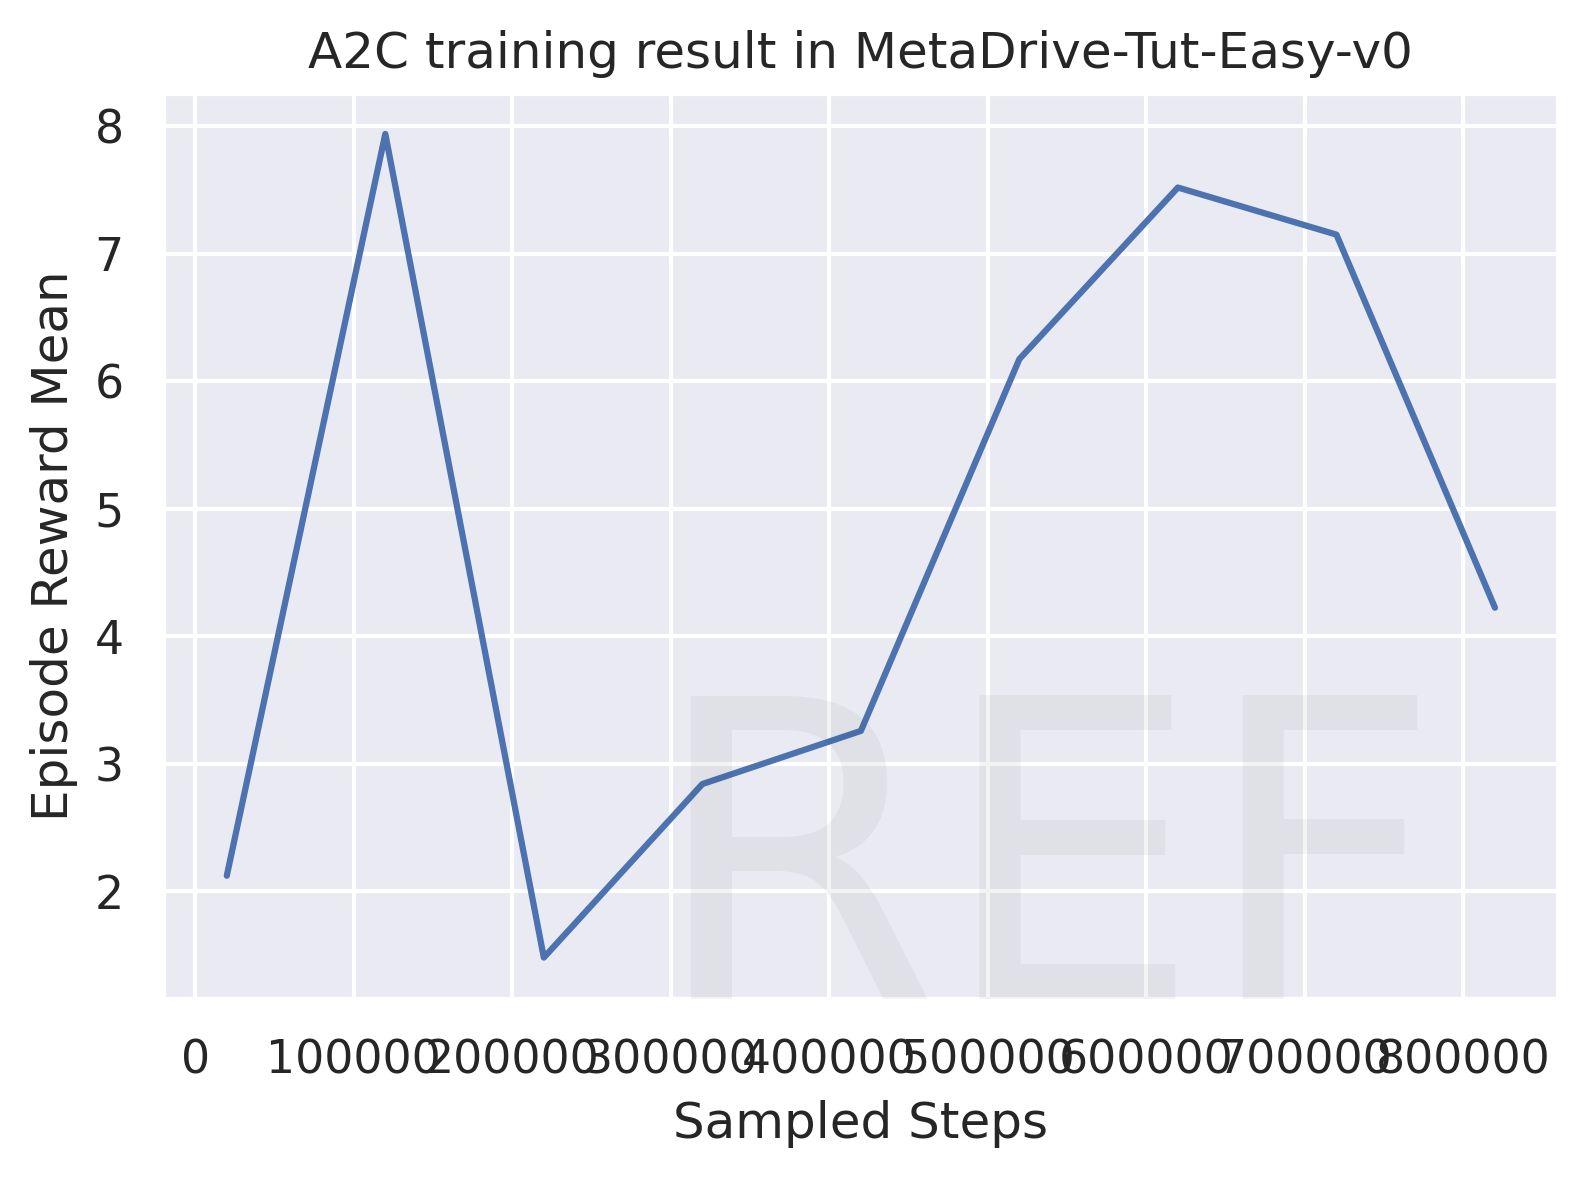

In [3]:
from core.utils import load_progress
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = load_progress("MetaDriveEasy/A2C")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="training_episode_reward/episode_reward_mean"
)
ax.set_title("A2C training result in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

# Note: The following figure is for reference used only, you don't have to repreduce it.


## Section 4: Finish PPO trainer and train a driving agent

You need to finish `core/ppo_trainer.py` and `core/buffer.py`.

Here we use GAE [1] (Generalized Advantage Estimation) to estimate the advantage. This technique is implemented in `PPORolloutStorage.compute_returns` in `core/buffer.py`. Concretely, we estimate the advantage of current state $t$ via:

$$\delta_t = r_t + \gamma V(s_t+1) - V(s_t)$$

$$A^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda) ^ l \delta_{t+l}$$

wherein $V$ is the state value function, $\lambda$ is a hyper-parameter defined in `core.ppo_trainer.ppo_config["gae_lambda"]`.

You can find that when $\lambda = 0$, the GAE estimates advantage in a one-step TD manner. When $\lambda = 1$, the GAE reduces to Monte Carlo Estimation of the state value. Therefore by varying the $\lambda$, we can make the trade-off between the accuracy of the estimation (bias) and the variance of advantage.

[1]: Schulman, John , et al. "High-Dimensional Continuous Control Using Generalized Advantage Estimation." (2015).

### Train and observe the learning curve of PPO in CartPole

In [ ]:
%run train.py --env-id CartPole-v0 --algo PPO --log-dir CartPole --num-envs 10 --max-steps 300000

In [ ]:
from core.utils import load_progress
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = load_progress("CartPole/PPO")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="training_episode_reward/episode_reward_mean"
)
ax.set_title("A2C training result in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

# Note: The following figure is for reference used only, you don't have to repreduce it.

### Train and observe the learning curve of PPO in MetaDrive Easy Env.

In [ ]:
%run train.py \
  --env-id MetaDrive-Tut-Easy-v0 \
  --algo PPO \
  --log-dir MetaDriveEasy \
  --num-envs 10 \
  --asynchronous \
  --max-steps 500000

In [ ]:
from core.utils import load_progress
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = load_progress("MetaDriveEasy/PPO")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="training_episode_reward/episode_reward_mean"
)
ax.set_title("PPO training result in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")
# ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="success_rate/success_rate_mean"
)
ax.set_title("PPO training result in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Success Rate Mean")
ax.set_xlabel("Sampled Steps")
# ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

# Note: The following figure is for reference used only, you don't have to repreduce it.

### Visualize the performance of PPO in MetaDrive Easy Env.

In [ ]:
# Load the agent using PolicyAPI (easy to use interface to get policy)

from core.envs import make_envs
import gym
from load_agents import PolicyAPI

env_name = "MetaDrive-Tut-Easy-v0"
policy = PolicyAPI(
    env_name,  # In order to get the observation shape
    num_envs=1, 
    log_dir="MetaDriveEasy/PPO/",
    suffix="final"
)

comp_env = gym.make(env_name, config={'use_render': True})
obs = comp_env.reset()
ep_rew = 0.0
for i in range(1000):
    frame = comp_env.render()
    obs, rew, term, _ = comp_env.step(policy(obs))
    ep_rew += rew
    if term:
        print("Episode reward: ", ep_rew)
        break
comp_env.close()
del comp_env
del policy

### Little example to use seaborn, pandas showing the hyper-parameter tuning results.

In [ ]:
from core.utils import load_progress
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y="training_episode_reward/episode_reward_mean"
# y="success_rate/success_rate_mean"
# y="learning_stats/entropy"
# y = "total_episodes"

dfs = []
    
df = load_progress("1105_w_grad_clip/PPO")
df["label"] = "10 Epoch, 1e-5 Lr, 0.3 clip param"
dfs.append(df)

df = load_progress("1105_small_clip_param/PPO")
df["label"] = "10 Epoch, 1e-5 Lr, 0.2 clip param"
dfs.append(df)

df = load_progress("1105_small_clip_param_large_mini_bs/PPO")
df["label"] = "10 Epoch, 1e-5 Lr, 0.2 clip param, 1024 mini bs"
dfs.append(df)

df = load_progress("1105_last_attempt/PPO")
df["label"] = "10 Epoch, 1e-5 Lr, 0.2 clip param, 256 mini bs"
dfs.append(df)

df = load_progress("1105_last_attempt_middle_lr/PPO")
df["label"] = "10 Epoch, 5e-5 Lr, 0.2 clip param, 256 mini bs"
dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index()

plt.figure(dpi=300)
sns.set("paper", "darkgrid")
ax = sns.lineplot(
    data=df,
    hue='label',
    x="total_steps",
    y=y
)
ax.set_title("PPO hyper-parameter searching in MetaDrive-Tut-10Env-v0")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Sampled Steps")
# ax.set_xlim(0, 1.1e6)
# ax.set_ylim(0, 8)
ax.legend(fontsize=8, loc="center right")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)



# Note: The following figure is for reference used only, you don't have to repreduce it.

## Section 5: You should also conduct the generalization experiments and draw relevent curves

The curves show the final training performance and the test performance varying with the number of training scenes. See `result.md` for details.

References:

[MetaDrive paper](https://arxiv.org/pdf/2109.12674.pdf)

[ProcGen paper](http://proceedings.mlr.press/v97/cobbe19a/cobbe19a.pdf)